In [1]:
from dolfinx import default_scalar_type
from dolfinx.fem import (dirichletbc, Expression, Function, functionspace, locate_dofs_topological)
from dolfinx.fem.petsc import LinearProblem
from dolfinx.io import XDMFFile
from dolfinx.io.gmshio import model_to_mesh
from dolfinx.mesh import compute_midpoints, locate_entities_boundary
from dolfinx import plot

from ufl import TestFunction, TrialFunction, as_vector, dot, dx, grad, inner
from mpi4py import MPI

import gmsh
import numpy as np
import pyvista

rank = MPI.COMM_WORLD.rank

In [2]:
gmsh.initialize()
R = 5
ri = 2
ro = 3
gdim = 2
model_rank = 0
mesh_comm = MPI.COMM_WORLD
if mesh_comm.rank == model_rank:
    background = gmsh.model.occ.addDisk(0, 0, 0, R, R)
    gmsh.model.occ.synchronize()
    inner_iron = gmsh.model.occ.addCircle(0,0,0,ri)
    outer_iron = gmsh.model.occ.addCircle(0,0,0,ro)
    gmsh.model.occ.addCurveLoop([outer_iron], 5)
    gmsh.model.occ.addCurveLoop([inner_iron], 6)
    iron = gmsh.model.occ.addPlaneSurface([5, 6])
    gmsh.model.occ.synchronize()
    whole_domain = gmsh.model.occ.fragment([(2, background)], [(2,iron)])
    gmsh.model.occ.synchronize()
    iron_surfaces = []
    background_surfaces = []
    for domain in whole_domain[0]:
        com = gmsh.model.occ.getCenterOfMass(domain[0], domain[1])
        mass = gmsh.model.occ.getMass(domain[0], domain[1])
        # Identify iron circle by its mass
        if np.isclose(mass, np.pi * (ro**2 - ri**2)):
            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], tag=1)
            iron_surfaces.append(domain)
        # Identify the background circle by its center of mass
        elif np.allclose(com, [0, 0, 0]):
            background_surfaces.append(domain[1])
    # Generate mesh
    element_size = 0.8
    order = 2
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", element_size);
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", element_size);
    gmsh.model.addPhysicalGroup(2, background_surfaces, tag=0)
    gmsh.option.setNumber("Mesh.Algorithm", 7)
    gmsh.option.setNumber("Mesh.ElementOrder", order) 
    gmsh.model.mesh.generate(gdim)
    gmsh.model.mesh.optimize("Netgen")


Info    : Meshing 1D...nts - Adding holes                                                                                
Info    : [  0%] Meshing curve 1 (Ellipse)
Info    : [ 40%] Meshing curve 2 (Circle)
Info    : [ 70%] Meshing curve 3 (Circle)
Info    : Done meshing 1D (Wall 0.000199287s, CPU 0.000317s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 2 (Plane, Bamg)
Info    : [  0%] BAMG succeeded 56 vertices 72 triangles
Info    : [ 40%] Meshing surface 3 (Plane, Bamg)
Info    : [ 40%] BAMG succeeded 144 vertices 224 triangles
Info    : [ 70%] Meshing surface 4 (Plane, Bamg)
Info    : [ 70%] BAMG succeeded 32 vertices 46 triangles
Info    : [ 70%] BAMG succeeded 30 vertices 42 triangles
Info    : [ 70%] BAMG succeeded 30 vertices 42 triangles
Info    : Done meshing 2D (Wall 0.141264s, CPU 0.060603s)
Info    : Meshing order 2 (curvilinear on)...
Info    : [  0%] Meshing curve 1 order 2
Info    : [ 20%] Meshing curve 2 order 2
Info    : [ 40%] Meshing curve 3 order 2
Info 

In [3]:
#for domain in whole_domain[0]:
#        com = gmsh.model.occ.getCenterOfMass(domain[0], domain[1])
#        mass = gmsh.model.occ.getMass(domain[0], domain[1])
#        # Identify iron circle by its mass
#        if np.isclose(mass, np.pi * (ro**2 - ri**2)):
#            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], tag=2)
#            iron_surfaces.append(domain)
#        # Identify the background circle by its center of mass
#        elif np.isclose(mass, np.pi*ri**2):
#            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], tag=0)
#            inner_surfaces.append(domain[1])
#        elif np.isclose(mass, np.pi*(R**2-ro**2)):
#            gmsh.model.addPhysicalGroup(domain[0], [domain[1]], tag=1)
#            outer_surfaces.append(domain[1])

In [4]:
mesh, ct, _ = model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=2)
gmsh.finalize()

In [5]:
with XDMFFile(MPI.COMM_WORLD, "mt.xdmf", "w") as xdmf:
    xdmf.write_mesh(mesh)
    xdmf.write_meshtags(ct, mesh.geometry)

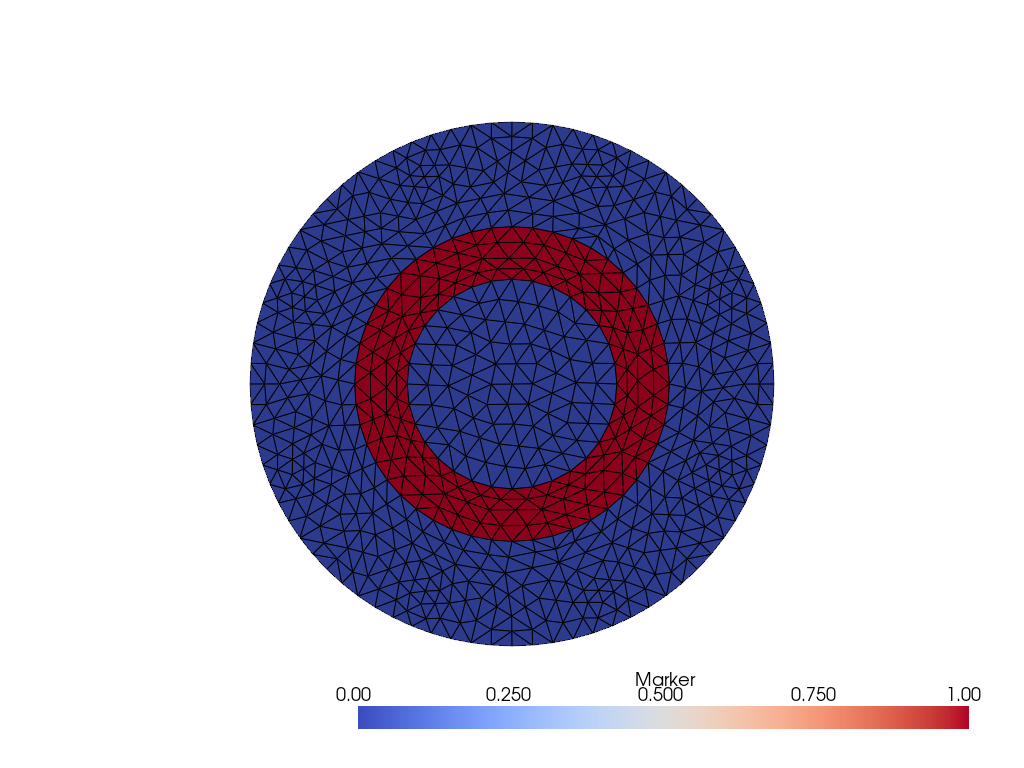

In [6]:
pyvista.start_xvfb()
plotter = pyvista.Plotter()
tdim = mesh.topology.dim
mesh.topology.create_connectivity(tdim, tdim)
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(mesh, tdim))
num_local_cells = mesh.topology.index_map(tdim).size_local
grid.cell_data["Marker"] = ct.values[ct.indices < num_local_cells]
grid.set_active_scalars("Marker")
actor = plotter.add_mesh(grid, show_edges=True, cmap="coolwarm")
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    cell_tag_fig = plotter.screenshot("cell_tags.png")

In [7]:
Q = functionspace(mesh, ("DG", 0))
material_tags = np.unique(ct.values)
mu = Function(Q) # define discontinuous function for permeability 
J = Function(Q) # define discontinuous function for current density 
# As we only set some values in J, initialize all as 0
J.x.array[:] = 0
J0 = 10
for tag in material_tags:
    cells = ct.find(tag)
    # Set values for mu
    if tag == 0:
        mu_ = 4 * np.pi * 1e-7  # Vacuum
        J_ = 0
    elif tag == 1:
        mu_ = 6.3e-3
        J_ = J0
    J.x.array[cells] = np.full_like(cells, J_, dtype=default_scalar_type)
    mu.x.array[cells] = np.full_like(cells, mu_, dtype=default_scalar_type)

In [8]:
#for tag in material_tags:
#    cells = ct.find(tag)
#    # Set values for mu
#    if tag == 0:
#        mu_ = 4 * np.pi * 1e-7  # Vacuum
#        J_ = 0
#    elif tag == 1:
#        mu_ = 4 * np.pi * 1e-7  # Vacuum
#        J_ = J0
#    elif tag == 2:
#        mu_ = 6.3e-3
#        J_ = J0
#    J.x.array[cells] = np.full_like(cells, J_, dtype=default_scalar_type)
#    mu.x.array[cells] = np.full_like(cells, mu_, dtype=default_scalar_type)

In [9]:
# first order Lagrange Finite Elements.
V = functionspace(mesh, ("Lagrange",1))
tdim = mesh.topology.dim
# mark the boundary faces
facets = locate_entities_boundary(mesh, tdim - 1, lambda x: np.full(x.shape[1], True))
# recover boundary dof
dofs = locate_dofs_topological(V, tdim - 1, facets)
# boundary conditions
dirichlet_bcs = dirichletbc(default_scalar_type(0), dofs, V)
# test and trial functions 
w = TestFunction(V)
A = TrialFunction(V)
# define lhs and rhs
lhs = (1/mu)*dot(grad(w),grad(A))*dx
rhs = w*J*dx

# setup the linear problem
problem = LinearProblem(lhs,rhs, bcs=[dirichlet_bcs])

# solve the linear problem and put the solution into a variable A_h
A_h = problem.solve()
A_h.name = "A"

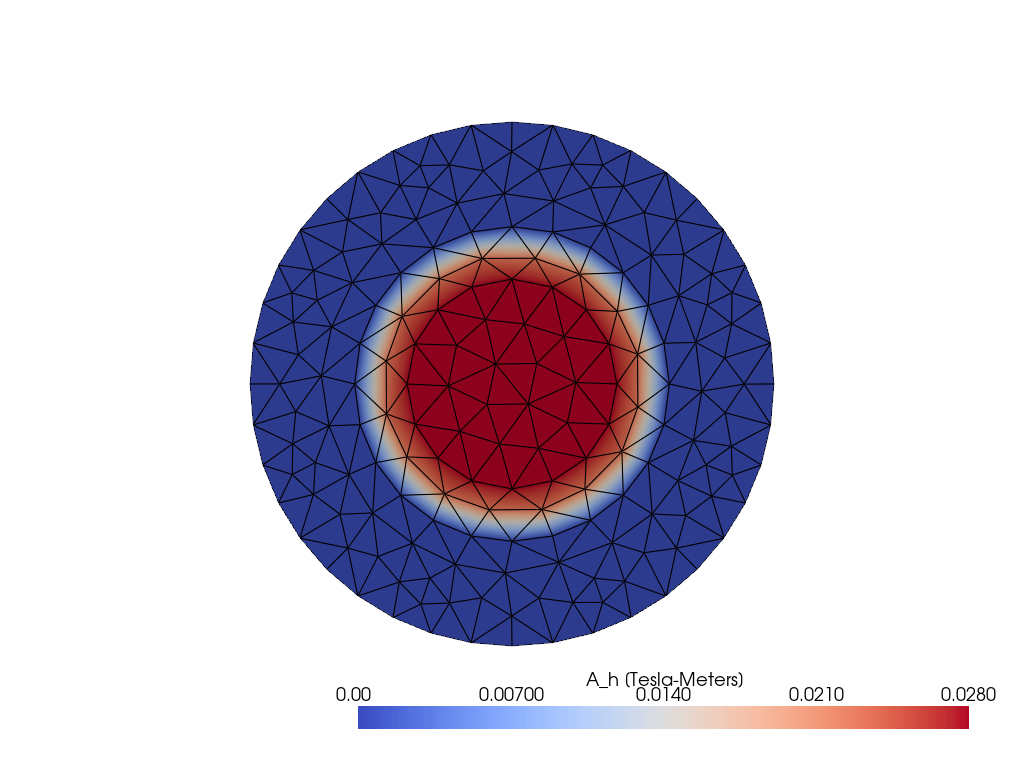

In [10]:
pyvista.start_xvfb()
Adim = mesh.topology.dim
mesh.topology.create_connectivity(Adim, Adim)
topology, cell_types, geometry = plot.vtk_mesh(mesh, Adim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
A_h_topology, A_h_cell_types, A_h_geometry = plot.vtk_mesh(V)

A_h_grid = pyvista.UnstructuredGrid(A_h_topology, A_h_cell_types, A_h_geometry)
A_h_grid.point_data["A_h [Tesla-Meters]"] = A_h.x.array.real
A_h_grid.set_active_scalars("A_h [Tesla-Meters]")
A_h_plotter = pyvista.Plotter()
A_h_plotter.add_mesh(A_h_grid, show_edges=True, cmap="coolwarm")
A_h_plotter.view_xy()
A_h_plotter.show()

In [11]:
W = functionspace(mesh, ("DG", 0, (mesh.geometry.dim, )))
B = Function(W)
B_expr = Expression(as_vector((A_h.dx(1), - A_h.dx(0))), W.element.interpolation_points())
B.interpolate(B_expr)
B.name = "B"

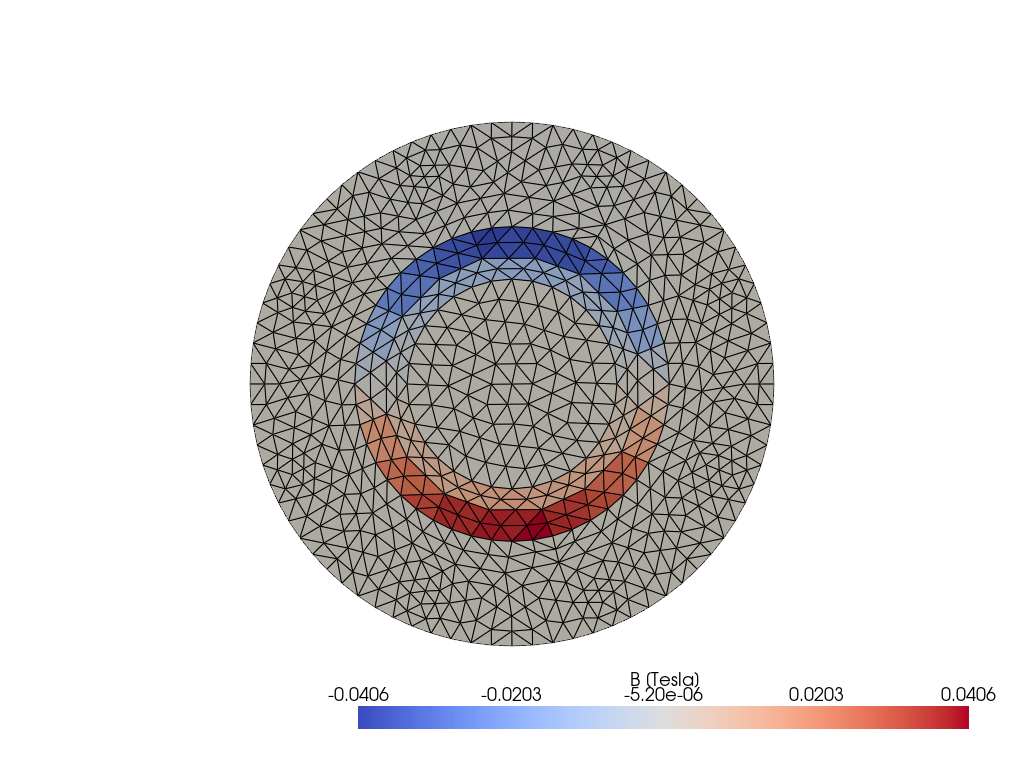

In [12]:
pyvista.start_xvfb()
plotter = pyvista.Plotter()
tdim = mesh.topology.dim
mesh.topology.create_connectivity(tdim, tdim)
grid = pyvista.UnstructuredGrid(*plot.vtk_mesh(mesh, tdim))
grid.cell_data["B [Tesla]"] = B.x.array.real[::2]
grid.set_active_scalars("B [Tesla]")
actor = plotter.add_mesh(grid, show_edges=True, cmap="coolwarm")
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    B_fig = plotter.screenshot("B.png")

In [13]:
mu = 6.3e-3
B_exact = mu/ro * J0*(ro**2-ri**2)/2

In [14]:
B_exact

0.05249999999999999

In [15]:
B_fem = max(B.x.array.real)
error = 100*abs(B_fem - B_exact)/B_exact

In [16]:
B_fem

0.04064881527049871

In [17]:
error

22.57368519905006